In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

from cvxopt import matrix, solvers

## Facility location problem

[Задача о размещении производства](https://ru.wikipedia.org/wiki/%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BE_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D0%B8_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2) (facility location problem) - это задача исследования операций, требующая найти оптимальное расположение объектов с целью минимизировать цены перевозок с учётом таких ограничений, как размещение опасных материалов вблизи жилищ.

<img src="https://disopt.epfl.ch/files/content/sites/disopt/files/users/190471/public/network_opt2.png">

Задано конечное множество возможных мест производства $I$ некоторой однородной продукции и конечное множество клиентов $J$. Известны затраты $c_i$ на организацию производства в пункте $i \in I$. Продукция доставляется клиентам, стоимость доставки клиенту $j \in J$ из пункта $i$ равна $d_{ij}$. Каждый клиент может обслуживаться только из _одного_ пункта. Необходимо определить, в каких пунктах следует разместить производство, чтобы обслужить _всех_ клиентов с наименьшими суммарными затратами.


\begin{gather}
\underset{x, y}{\text{min}} & \sum_{i \in I}c_i y_i + \sum_{j \in J} \sum_{i \in I} d_{ij} x_{ij} \\
\text{s.t.} & \sum_{i \in I} x_{ij} = 1, \forall j \in J \\
& y_i \geq x_{ij}, \forall i \in I,  \forall j \in J  \\
& y_i \in \{0,1\}, x_{ij} \in \{0,1\} \\
\end{gather}

Если $y_i = 1$, то это означает, что производство $i$ открыто. Если $x_{ij} = 1$, то это означает, что производство $i$ обслудивает клиента $j$.

Первое условие означает, что спрос потребителей удовлетворен: потребитель $j$ обслуживается одним производством.

Второе условие означает, что если производство $i$ не открыто ($y_i = 0$), то оно не может обслудивать ни одного потребителя ($x_{ij} = 0$).

### LP-релаксация:

$y_i \in [0,1], x_{ij} \in [0,1]$

Лагранжиан:
\begin{gather}
L(y,x,\lambda, \mu) = \sum_{i \in I}c_i y_i + \sum_{j \in J} \sum_{i \in I} d_{ij} x_{ij} + \sum_{j \in J} \sum_{i \in I} \lambda_{ij} (x_{ij} - y_i) + \sum_{j \in J} \mu_j \left(\sum_{i \in I} x_{ij} - 1 \right) = \\
\sum_{i \in I} c_i y_i + \sum_{i \in I} \sum_{j \in J} d_{ij} x_{ij} + \sum_{i \in I} \sum_{j \in J} \lambda_{ij} x_{ij} - \sum_{i \in I} y_i \sum_{j \in J} \lambda_{ij} + \sum_{i \in I} \sum_{j \in J} \mu_j (x_{ij} - 1) = \\
\sum_{i \in I} (c_i - \sum_{j \in J} \lambda_{ij}) y_i +  \sum_{i \in I} \sum_{j \in J} (d_{ij} + \lambda_{ij} + \mu_j)x_{ij} - \sum_{i \in I}\sum_{j \in J} \mu_j = \\
\sum_{i \in I} \left( (c_i - \sum_{j \in J} \lambda_{ij}) y_i +  \sum_{j \in J} (d_{ij} + \lambda_{ij} + \mu_j)x_{ij} - \sum_{j \in J} \mu_j \right)
\end{gather}

Двоственная функция:

$$g(\lambda, \mu) = \min_{y_i \in [0,1], x_{ij} \in [0,1]} L(y,x,\lambda, \mu)$$

Найдем максимум двойственной задачи методом проекции субградиента.

Значения $x_{*ij} - y_{*i}$ и $\sum_{i \in I} x_{*ij} - 1$, где $(y_*, x_*) = \arg\min_{y,x} L(y,x,\lambda, \mu)$, являются элементами суперградиента недифференцируемой функции $g(\lambda, \mu)$, поэтому могут быть ненулевым даже в оптимальной точке - решении двойственной задачи.

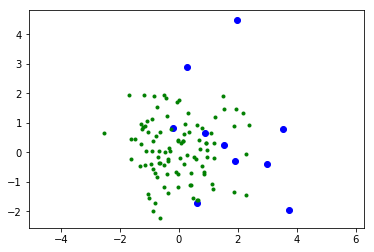

In [4]:
dim = 2

M = 10 # i
N = 100 # j

np.random.seed(0)

facilities = np.random.randn(M,dim)*2
clients = np.random.randn(N,dim)

plt.plot(facilities[:,0], facilities[:,1], 'bo')
plt.plot(clients[:,0], clients[:,1], 'g.')
plt.axis('equal')
plt.show()

In [5]:
def L2_distance(X,Y):
    return -2.*X.dot(Y.T) + np.sum(X*X, axis=1, keepdims=True) + np.sum(Y*Y, axis=1, keepdims=True).T

In [6]:
c = np.ones((M,1))

# pairwise distances
d = L2_distance(facilities, clients)
print(d.shape)

(10, 100)


In [7]:
MAX_ITER = 2000

f_dual = []

#alpha = 0.1

lmbda = np.random.rand(M, N)
mu = np.random.rand(1,N)

proj = lambda x: np.clip(x, 0, np.inf)

for i in range(MAX_ITER):
    
    c_ = c - np.sum(lmbda, axis=1)[:,np.newaxis]
    y = 1.0*(c_ < 0)
    d_ = d + lmbda + mu
    x = 1.0*(d_ < 0)
          
    subgrad_lmbda = x - y
    subgrad_mu = np.sum(x, axis=0) - 1.
    
    alpha = 0.5/(i+1)
    
    L = np.sum(c*y) + np.sum(d*x) + np.sum(lmbda*subgrad_lmbda) + np.sum(mu*subgrad_mu)
    f_dual.append(L)
        
    lmbda = proj(lmbda + alpha*subgrad_lmbda)
    mu = mu + alpha*subgrad_mu
    
print(np.c_[y, x.sum(axis=1)])
print(x.sum(axis=0))

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 1.  3.]
 [ 1. 51.]
 [ 0.  0.]
 [ 1.  8.]
 [ 1. 15.]
 [ 0.  0.]
 [ 1. 22.]]
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


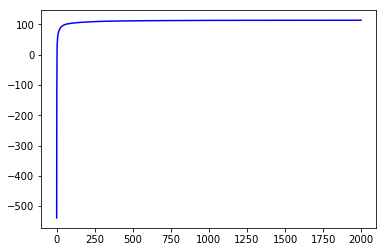

In [8]:
it = range(MAX_ITER)
plt.plot(it, f_dual, 'b-')

[3 4 6 7 9]


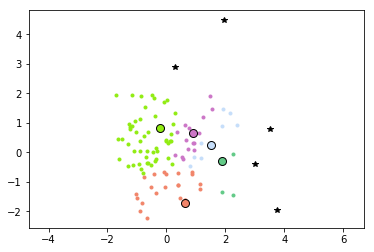

In [9]:
opened_idx = np.nonzero(y)[0]
print(opened_idx)

np.random.seed(0)
colors = np.random.rand(M,3)

idx = np.argmax(x, axis=0)

for i in range(M):
    if y[i] == 0:
        plt.plot(facilities[i,0], facilities[i,1], 'k*')
    else:
        plt.plot(clients[idx==i,0], clients[idx==i,1], marker='.', color=colors[i,:], linewidth=0)
        plt.plot(facilities[i,0], facilities[i,1], marker='o', color=colors[i,:], markersize=8, markeredgewidth=1., markeredgecolor=(0, 0, 0, 1))

plt.axis('equal')        
plt.show()